In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2026-02-22 21:02:04.734667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771794124.977198      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771794125.040974      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771794125.539334      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771794125.539370      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771794125.539372      55 computation_placer.cc:177] computation placer alr

In [2]:
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0

            images.append(img)
            labels.append(label)

    return images, labels

With_Mask_path = '/kaggle/input/face-mask-detection/dataset/with_mask'
Without_Mask_path = '/kaggle/input/face-mask-detection/dataset/without_mask'

With_Mask_images, With_Mask_labels = load_images_from_folder(With_Mask_path, 1)
Without_Mask_images, Without_Mask_labels = load_images_from_folder(Without_Mask_path, 0)

X = np.array(With_Mask_images + Without_Mask_images)
y = np.array(With_Mask_labels + Without_Mask_labels)

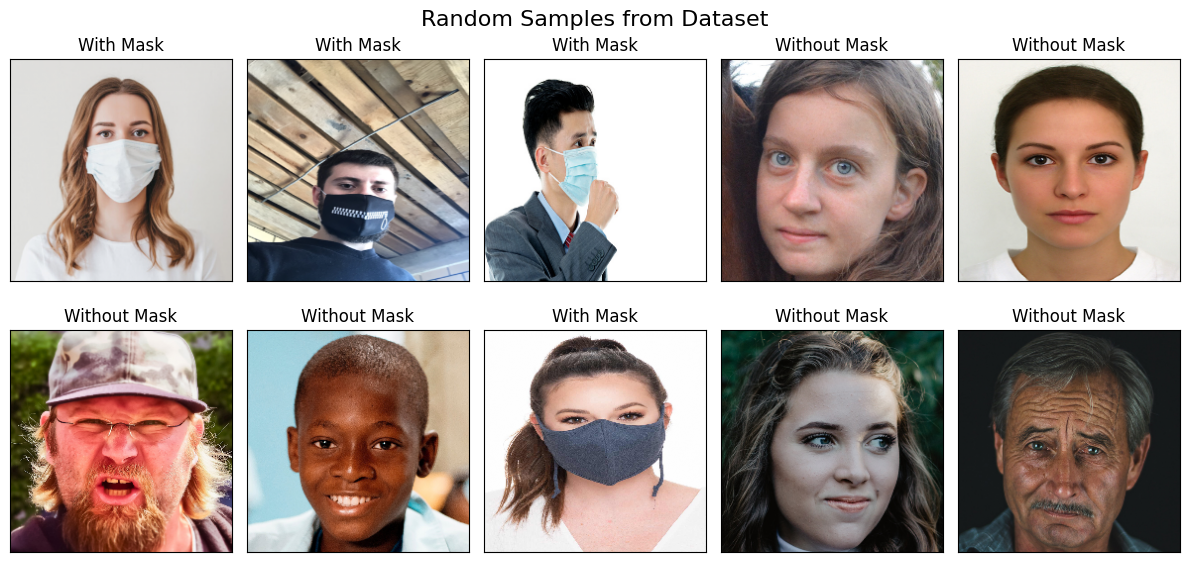

In [6]:
plt.figure(figsize=(12, 6))

for i, idx in enumerate(np.random.choice(len(X), 10, replace=False)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx]) 
    plt.title("Without Mask" if y[idx] == 0 else "With Mask", fontsize=12) # Corrected title
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Random Samples from Dataset', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Without Mask: 220 images
With Mask: 220 images


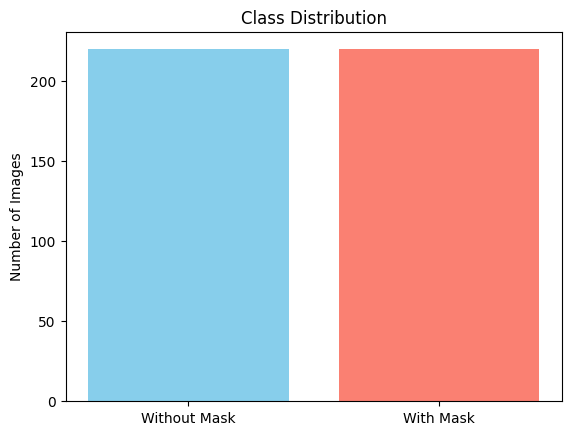

In [7]:
unique, counts = np.unique(y, return_counts=True)

for label, count in zip(unique, counts):
    class_name = "Without Mask" if label == 0 else "With Mask"
    print(f"{class_name}: {count} images")

# Optional: visualize the balance
plt.bar(["Without Mask", "With Mask"], counts, color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

base_model.trainable = True

fine_tune_at = int(len(base_model.layers) * 0.8) 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 739ms/step - accuracy: 0.7740 - loss: 0.4126 - val_accuracy: 0.9659 - val_loss: 0.0540
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9919 - loss: 0.0228 - val_accuracy: 0.9773 - val_loss: 0.0390
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9773 - val_loss: 0.0345
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9773 - val_loss: 0.0290
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9773 - val_loss: 0.0282
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 749ms/step - accuracy: 0.9232 - loss: 0.1848 - val_accuracy: 0.9773 - val_loss: 0.0266
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9531 - loss: 0.1173 - val_accuracy: 0.9773 - val_loss: 0.0260
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9881 - loss: 0.0494 - val_accuracy: 0.9886 - va

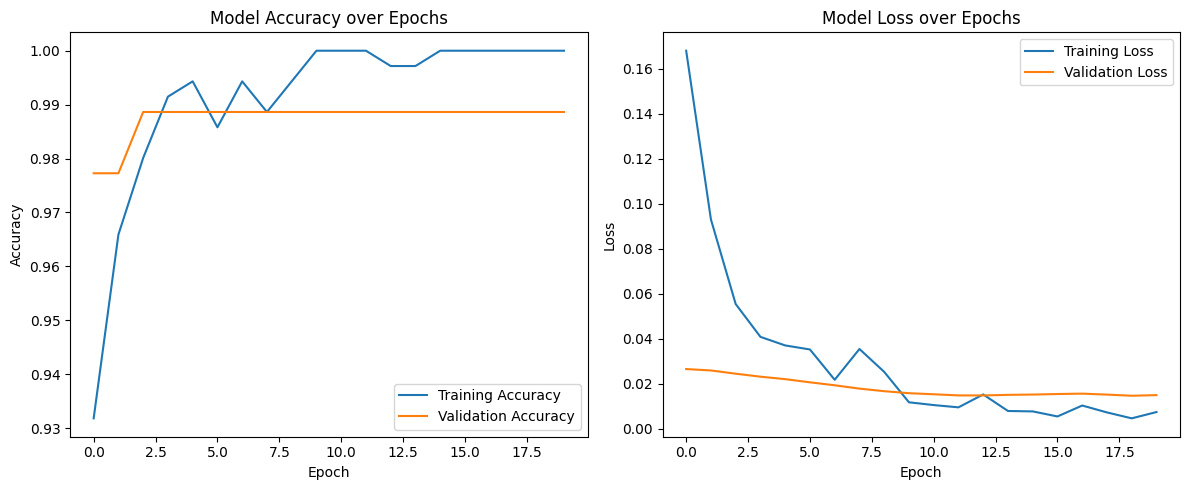

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9904 - loss: 0.0124   
Test accuracy: 0.9886363744735718


In [17]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=["Without Mask", "With Mask"])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Confusion Matrix:
[[44  0]
 [ 1 43]]

Classification Report:
              precision    recall  f1-score   support

Without Mask       0.98      1.00      0.99        44
   With Mask       1.00      0.98      0.99        44

    accuracy                           0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


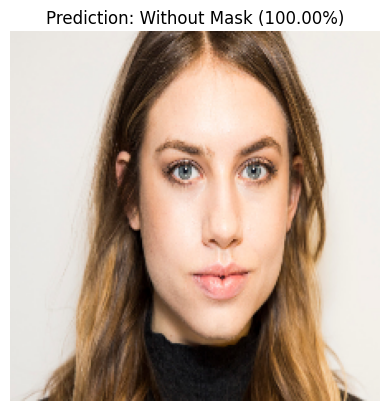

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_mask(image_path, model):
    img = cv2.imread(image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_resized = cv2.resize(img_rgb, (224, 224)) 
    img_normalized = img_resized / 255.0          
    
    img_final = np.expand_dims(img_normalized, axis=0)

    prediction = model.predict(img_final)
    
    result = "With Mask" if prediction[0][0] > 0.5 else "Without Mask"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    plt.imshow(img_resized)
    plt.title(f"Prediction: {result} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

image_path = '/kaggle/input/face-mask-detection/dataset/without_mask/image_1.png' 
predict_mask(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


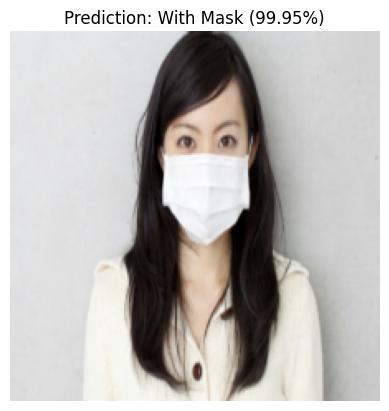

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_mask(image_path, model):
    img = cv2.imread(image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_resized = cv2.resize(img_rgb, (224, 224)) 
    img_normalized = img_resized / 255.0          
    
    img_final = np.expand_dims(img_normalized, axis=0)

    prediction = model.predict(img_final)
    
    result = "With Mask" if prediction[0][0] > 0.5 else "Without Mask"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    plt.imshow(img_resized)
    plt.title(f"Prediction: {result} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

image_path = '/kaggle/input/face-mask-detection/dataset/with_mask/image_211.png' 
predict_mask(image_path, model)